In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/Weather"
!ls

/content/drive/My Drive/Weather
Dataset


In [48]:
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [49]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [50]:
data_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                          std = [0.229, 0.224, 0.225])
                                     ])

dataset = ImageFolder(root = "./Dataset", transform=data_transforms)


In [51]:





train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

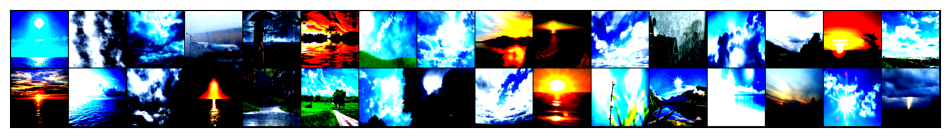

In [52]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(tl):
  for images, lables in tl:
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
    break

show_batch(train_loader)


In [59]:
import torch.nn as nn
import torch.nn.functional as F

class WeatherCNN(nn.Module):

    def __init__(self):
        super(WeatherCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x= x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

class EarlyStopper:
    def __init__(self, patience = 1, min_delta = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
              return True
        return False


model = WeatherCNN().to(device)
early_stopper = EarlyStopper(patience = 10, min_delta = 0)


In [60]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)


num_epochs = 100
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() # setting gradients as zero
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    # ------------------------------------------------------ #
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_list.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct/total:.2f}%')

    if early_stopper.early_stop(avg_val_loss):
      print("Model is Overfitting from :-" + str(epoch) + " epoch")
      break



torch.save(model.state_dict(), "trained_model.pth")
print("MODEL SAVED AS 'trained_model.pth'")


Epoch [1/100], Loss: 1.3754, Validation Loss: 0.8509, Accuracy: 64.89%
Epoch [2/100], Loss: 0.6764, Validation Loss: 0.5829, Accuracy: 81.78%
Epoch [3/100], Loss: 0.4948, Validation Loss: 0.3367, Accuracy: 84.89%
Epoch [4/100], Loss: 0.4033, Validation Loss: 0.4292, Accuracy: 76.89%
Epoch [5/100], Loss: 0.3978, Validation Loss: 0.3015, Accuracy: 84.89%
Epoch [6/100], Loss: 0.3385, Validation Loss: 0.3243, Accuracy: 84.44%
Epoch [7/100], Loss: 0.2763, Validation Loss: 0.2570, Accuracy: 88.00%
Epoch [8/100], Loss: 0.2183, Validation Loss: 0.2648, Accuracy: 88.44%
Epoch [9/100], Loss: 0.1856, Validation Loss: 0.2414, Accuracy: 91.56%
Epoch [10/100], Loss: 0.1440, Validation Loss: 0.2665, Accuracy: 88.44%
Epoch [11/100], Loss: 0.1085, Validation Loss: 0.2750, Accuracy: 91.11%
Epoch [12/100], Loss: 0.0728, Validation Loss: 0.2321, Accuracy: 90.67%
Epoch [13/100], Loss: 0.0400, Validation Loss: 0.3215, Accuracy: 91.11%
Epoch [14/100], Loss: 0.0649, Validation Loss: 0.2313, Accuracy: 92.44%
E

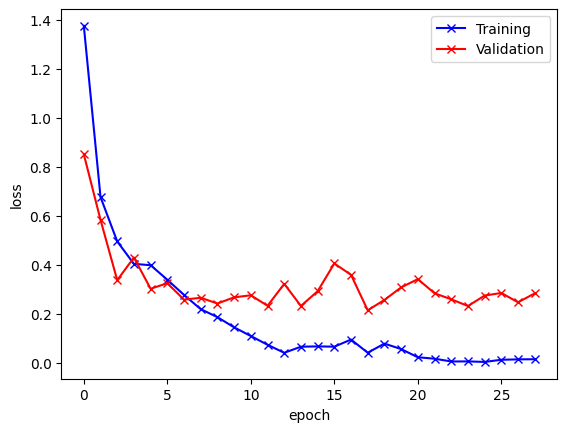

In [61]:


plt.plot(train_loss_list, '-bx')
plt.plot(val_loss_list, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])

## Testing on random Image


Prediction ->  Rainy


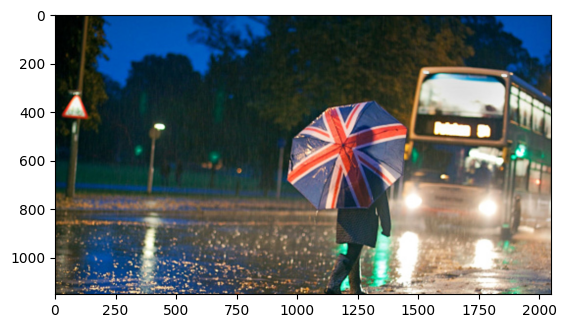

In [72]:
from PIL import Image

def load_image(img_path):
    image = Image.open(img_path).convert("RGB")
    plt.imshow(image)
    image = data_transforms(image)
    image = image.unsqueeze(0)
    return image

def predict_image(img_path):
    image = load_image(img_path).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    return predicted.item()


class_labels = ["Cloudy", "Rainy", "Shine", "Sunrise"]
test_model = WeatherCNN().to(device)
test_model.load_state_dict(torch.load("trained_model.pth"))
model.eval()
img_path = "./test2.png"
predicted_index = predict_image(img_path)
predicted_label = class_labels[predicted_index]
print("Prediction -> ", predicted_label)
